In [17]:
import os
from datetime import datetime
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as colors
import seaborn as sns
import geopandas as gpd

import pyarrow as pa
import pyarrow.parquet as pq

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

day_of_week: 0 = Sunday
1 = Monday
2 = Tuesday
3 = Wednesday
4 = Thursday
5 = Friday
6 = Saturday

In [18]:
cwd = os.getcwd()
print("Current Working Directory:", cwd)

Current Working Directory: c:\Users\35385\Desktop\CS_Summer_2024\Shared_GH\New-York-App\data-analytics\analysis


In [19]:
combined_df_dir = os.path.join(os.getcwd(), "..", "Datasets", "taxi_other")

# Define the directory where the data is located relative to the current working directory
print("Taxi Zone CSV Directory:", combined_df_dir)

# Define the file path relative to the data directory
combined_df_path = os.path.join(cwd, combined_df_dir, "combined_df.csv")

df = pd.read_csv(combined_df_path, keep_default_na=True, delimiter=",", skipinitialspace=True, encoding="Windows-1252")

Taxi Zone CSV Directory: c:\Users\35385\Desktop\CS_Summer_2024\Shared_GH\New-York-App\data-analytics\analysis\..\Datasets\taxi_other


In [20]:
df

,datetime_formatted,hour,day_of_week,week,month,day_of_month,year_month,zone,passenger_count
0,2021-01-01 00:00:00,0,4,53,0,1,2021-01,4,4
1,2021-01-01 00:00:00,0,4,53,0,1,2021-01,13,3
2,2021-01-01 00:00:00,0,4,53,0,1,2021-01,24,3
3,2021-01-01 00:00:00,0,4,53,0,1,2021-01,41,12
4,2021-01-01 00:00:00,0,4,53,0,1,2021-01,42,2
...,...,...,...,...,...,...,...,...,...
1745581,2024-04-01 00:00:00,0,0,14,3,1,2024-04,246,46
1745582,2024-04-01 00:00:00,0,0,14,3,1,2024-04,249,72
1745583,2024-04-01 00:00:00,0,0,14,3,1,2024-04,261,11
1745584,2024-04-01 00:00:00,0,0,14,3,1,2024-04,262,35


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1745586 entries, 0 to 1745585
Data columns (total 9 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   datetime_formatted  object
 1   hour                int64 
 2   day_of_week         int64 
 3   week                int64 
 4   month               int64 
 5   day_of_month        int64 
 6   year_month          object
 7   zone                int64 
 8   passenger_count     int64 
dtypes: int64(7), object(2)
memory usage: 119.9+ MB


In [22]:
# """ 
# Treating variables as categorical may capture the distinct categories without assuming an inherent ordering, which might be more appropriate for analysis.
# """

# df['datetime_formatted'] = pd.to_datetime(df['datetime_formatted'])
# # Convert categorical columns to categorical data type
# cat_cols = ['day_of_week', 'week', 'month', 'day_of_month', 'year_month', 'zone']
# df[cat_cols] = df[cat_cols].astype('category')

# # Now check the data types again
# print(df.dtypes)

In [23]:
passenger_count = df["passenger_count"]

stats = passenger_count.describe()

missing_percentage = (passenger_count.isnull().mean() * 100).round(2)

cardinality = passenger_count.nunique()

total_value = passenger_count.sum()

# Prepare the report DataFrame
report = pd.DataFrame(columns=["Count", "Mean", "Std", "Min", "25%", "50%", "75%", "Max", "Missing%", "Cardinality", "Total"])

# Populate the report DataFrame
report.loc["passenger_count"] = [
    stats["count"], 
    stats["mean"], 
    stats["std"], 
    stats["min"], 
    stats["25%"], 
    stats["50%"], 
    stats["75%"], 
    stats["max"], 
    f"{missing_percentage}%", 
    cardinality,
    total_value
]

report.T

,passenger_count
Count,1745586.0
Mean,152.284147
Std,182.2845
Min,1.0
25%,20.0
50%,80.0
75%,224.0
Max,1734.0
Missing%,0.0%
Cardinality,1424


count: number of entries in each (hour) group.
mean: average number of passengers per ride in each group.
cardinality:  number of unique passenger counts in each group.
total_passenger_count: total number of passengers for all rides in each group.

In [24]:
def compute_stats(df, groupby_column):
    grouped = df.groupby(groupby_column)["passenger_count"].describe()
    grouped["cardinality"] = df.groupby(groupby_column)["passenger_count"].apply(lambda x: x.nunique())
    grouped["total_passenger_count"] = df.groupby(groupby_column)["passenger_count"].sum()
    return grouped.sort_values(by="total_passenger_count", ascending=False)

# List of columns to group by
groupby_columns = ["hour", "day_of_week", "week", "month", "day_of_month", "year_month", "zone"]

# Dictionary to store the results
stats_by_category = {}

# Compute stats for each category
for column in groupby_columns:
    stats_by_category[column] = compute_stats(df, column)

# Display the results for each category
for column, stats in stats_by_category.items():
    print(f"Stats for passenger_count by {column}:")
    print(stats)
    print("\n")

Stats for passenger_count by hour:
        count        mean         std  min   25%    50%    75%     max  \
hour                                                                     
18    74638.0  259.356816  237.431862  1.0  64.0  196.0  392.0  1531.0   
19    74590.0  256.693618  232.691357  1.0  63.0  194.0  391.0  1584.0   
17    74992.0  235.395322  218.704645  1.0  56.0  178.0  355.0  1431.0   
16    74905.0  229.975502  216.774863  1.0  56.0  174.0  345.0  1486.0   
15    74588.0  229.622741  218.888388  1.0  56.0  172.0  343.0  1551.0   
20    74385.0  219.542798  194.658515  1.0  56.0  166.0  339.0  1217.0   
14    74464.0  214.501477  203.437938  1.0  53.0  161.0  319.0  1358.0   
13    74364.0  206.036133  195.518103  1.0  50.0  155.0  307.0  1331.0   
21    74146.0  198.852548  178.487806  1.0  50.0  146.0  309.0  1181.0   
12    74189.0  197.249687  190.612160  1.0  47.0  146.0  293.0  1247.0   
22    74023.0  191.299974  178.730114  1.0  48.0  135.0  289.0  1179.0   
11 

In [25]:
#number of unique values in "zone"
num_unique_zones = df["zone"].nunique()
print("Number of unique zones:", num_unique_zones)

Number of unique zones: 67


C:\Users\35385\AppData\Local\Temp\ipykernel_21664\4043606631.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_proportions.index, y=sorted_proportions.values, order=sorted_proportions.index, palette="viridis")


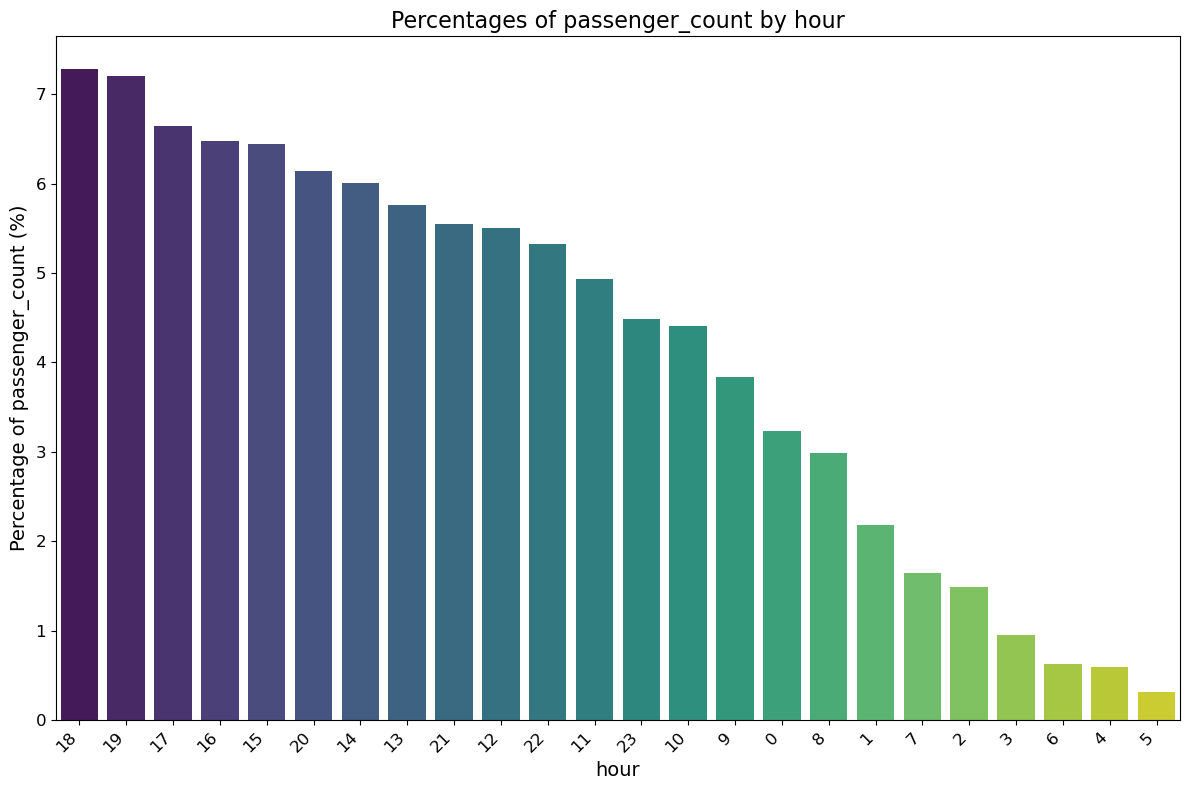

C:\Users\35385\AppData\Local\Temp\ipykernel_21664\4043606631.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_proportions.index, y=sorted_proportions.values, order=sorted_proportions.index, palette="viridis")


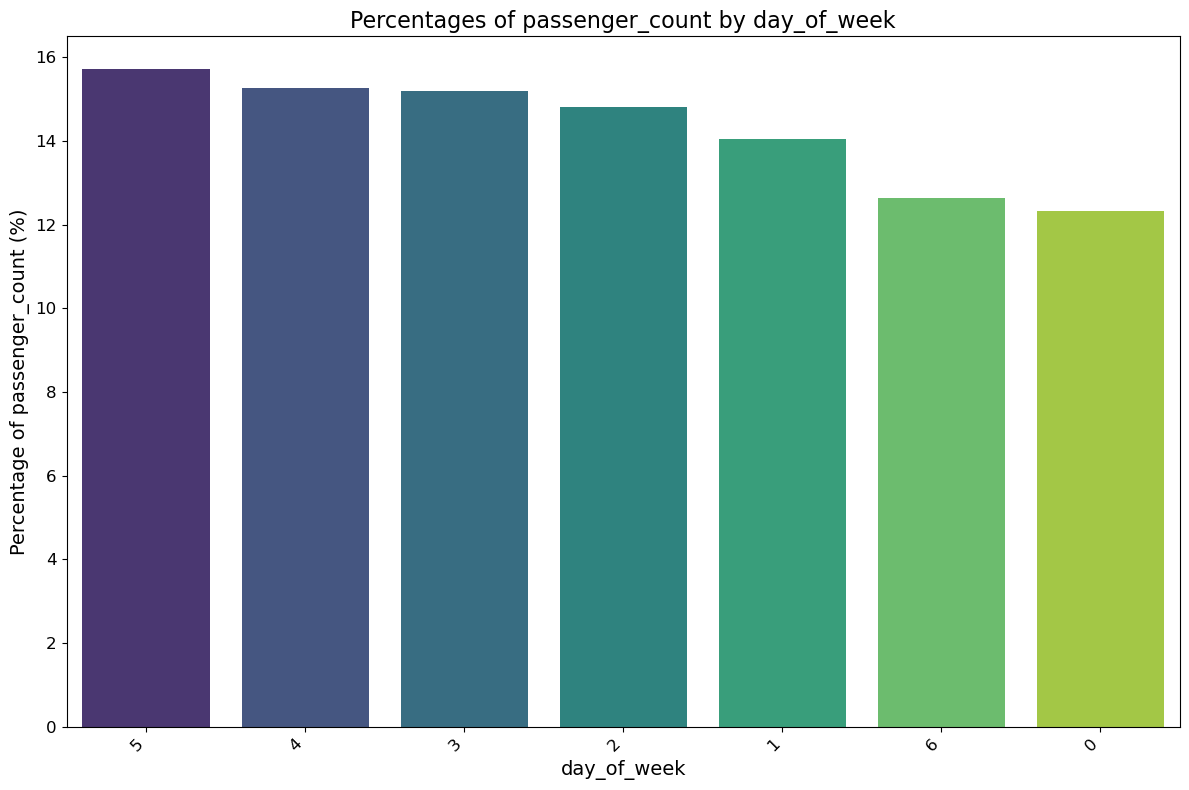

C:\Users\35385\AppData\Local\Temp\ipykernel_21664\4043606631.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_proportions.index, y=sorted_proportions.values, order=sorted_proportions.index, palette="viridis")


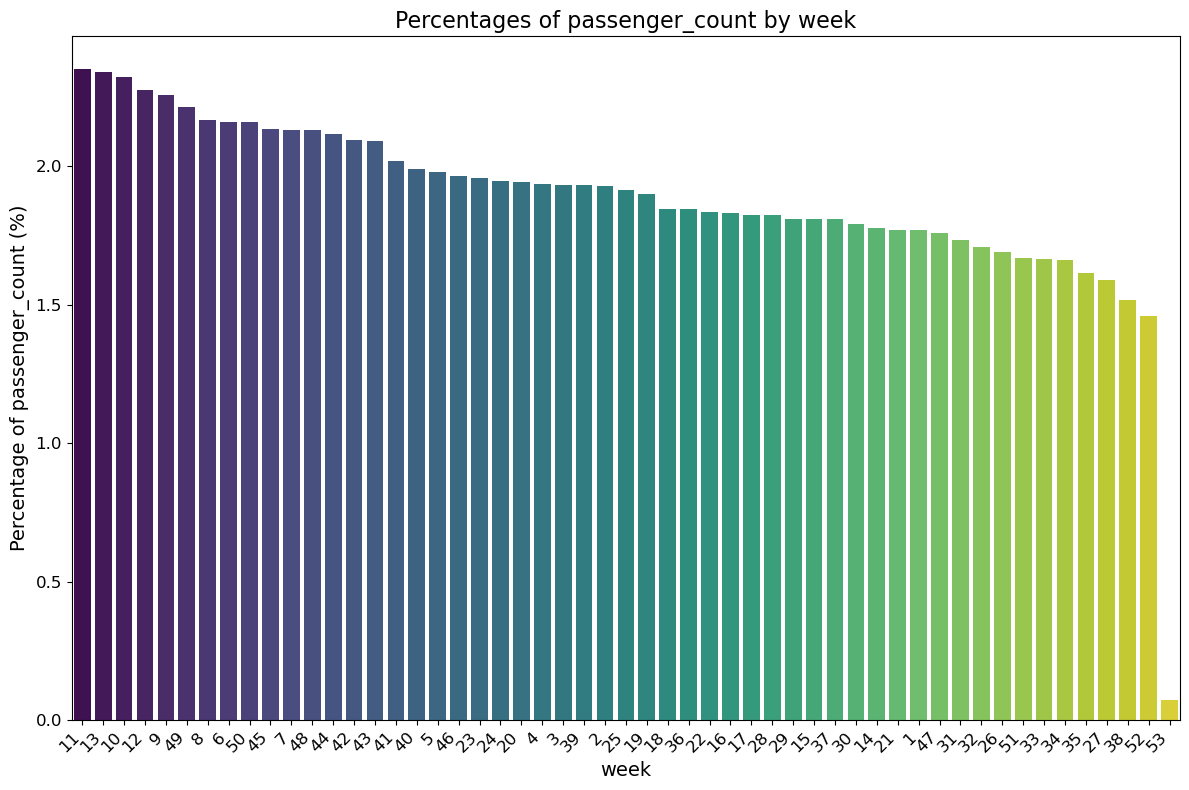

C:\Users\35385\AppData\Local\Temp\ipykernel_21664\4043606631.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_proportions.index, y=sorted_proportions.values, order=sorted_proportions.index, palette="viridis")


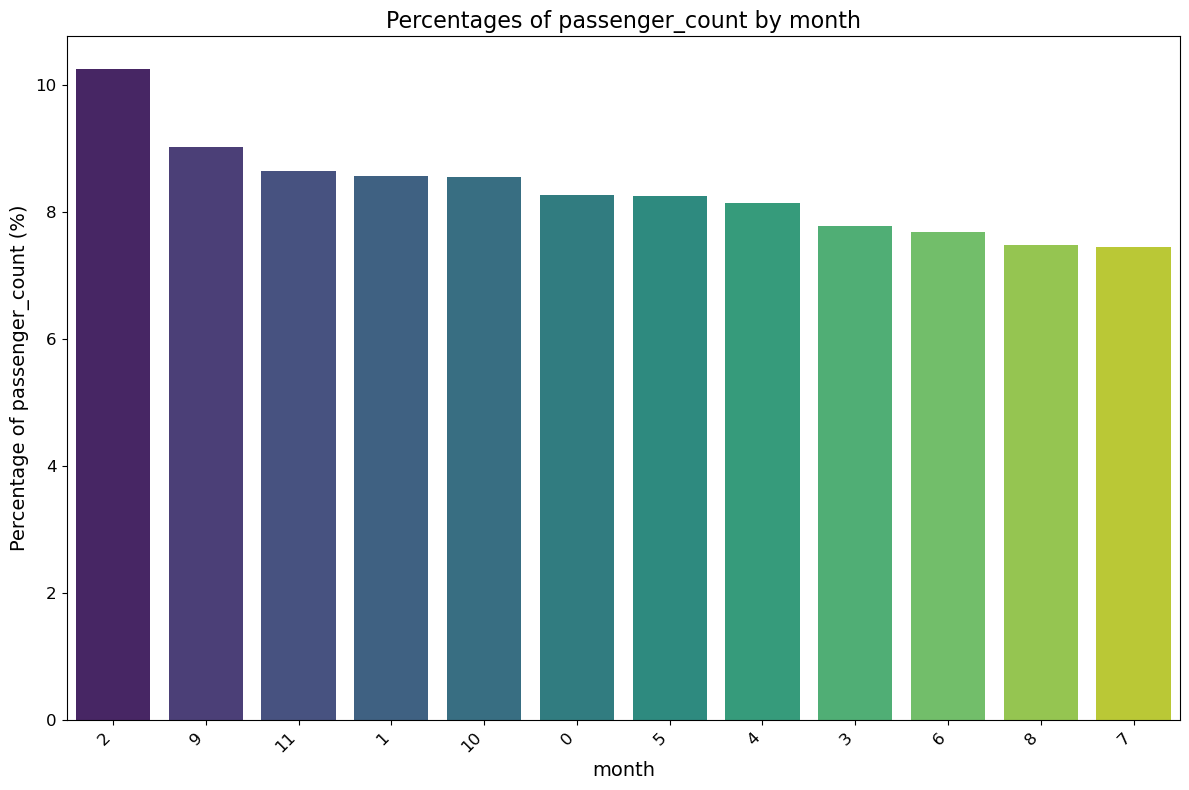

C:\Users\35385\AppData\Local\Temp\ipykernel_21664\4043606631.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_proportions.index, y=sorted_proportions.values, order=sorted_proportions.index, palette="viridis")


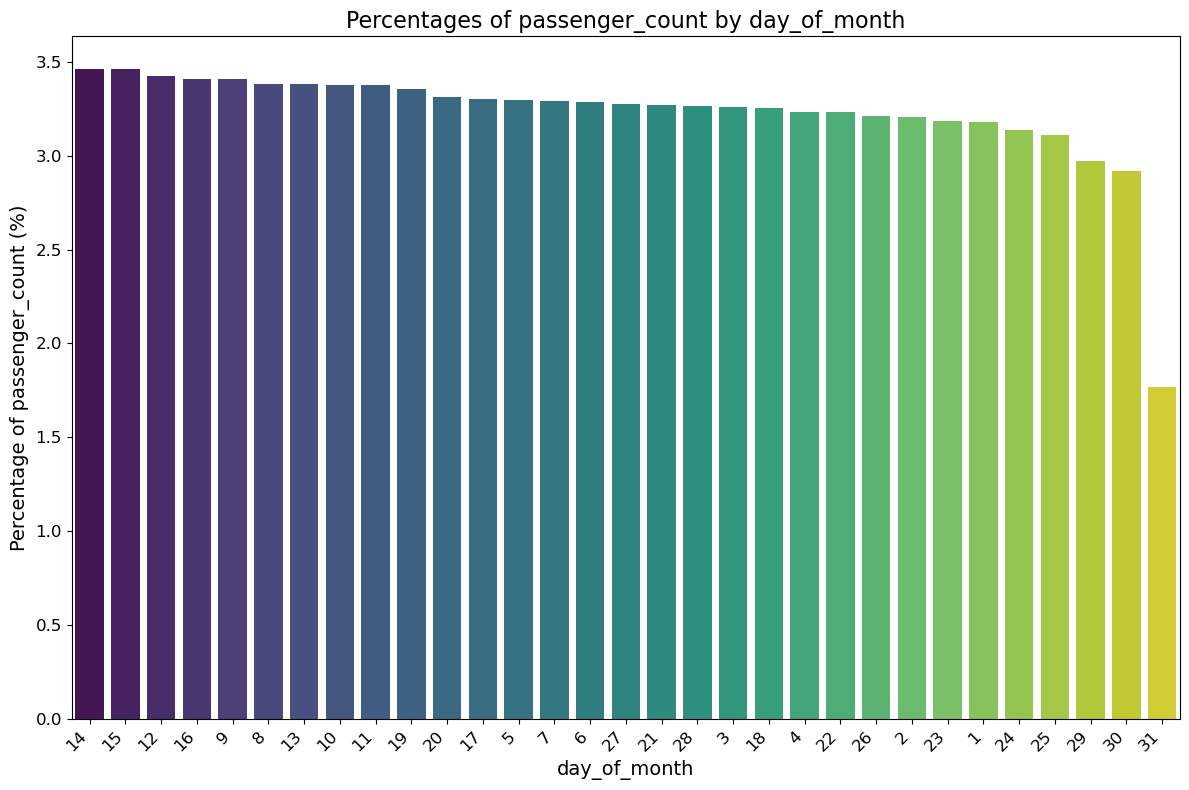

C:\Users\35385\AppData\Local\Temp\ipykernel_21664\4043606631.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_proportions.index, y=sorted_proportions.values, order=sorted_proportions.index, palette="viridis")


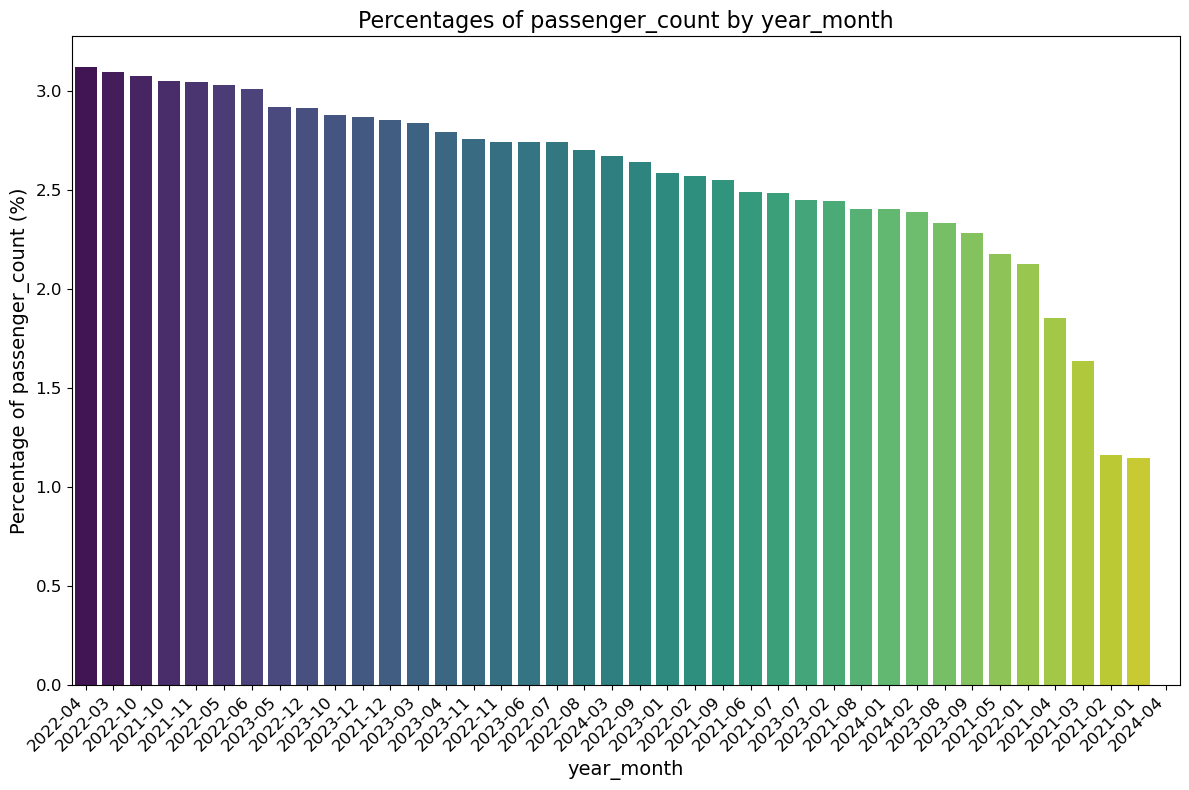

C:\Users\35385\AppData\Local\Temp\ipykernel_21664\4043606631.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_proportions.index, y=sorted_proportions.values, order=sorted_proportions.index, palette="viridis")


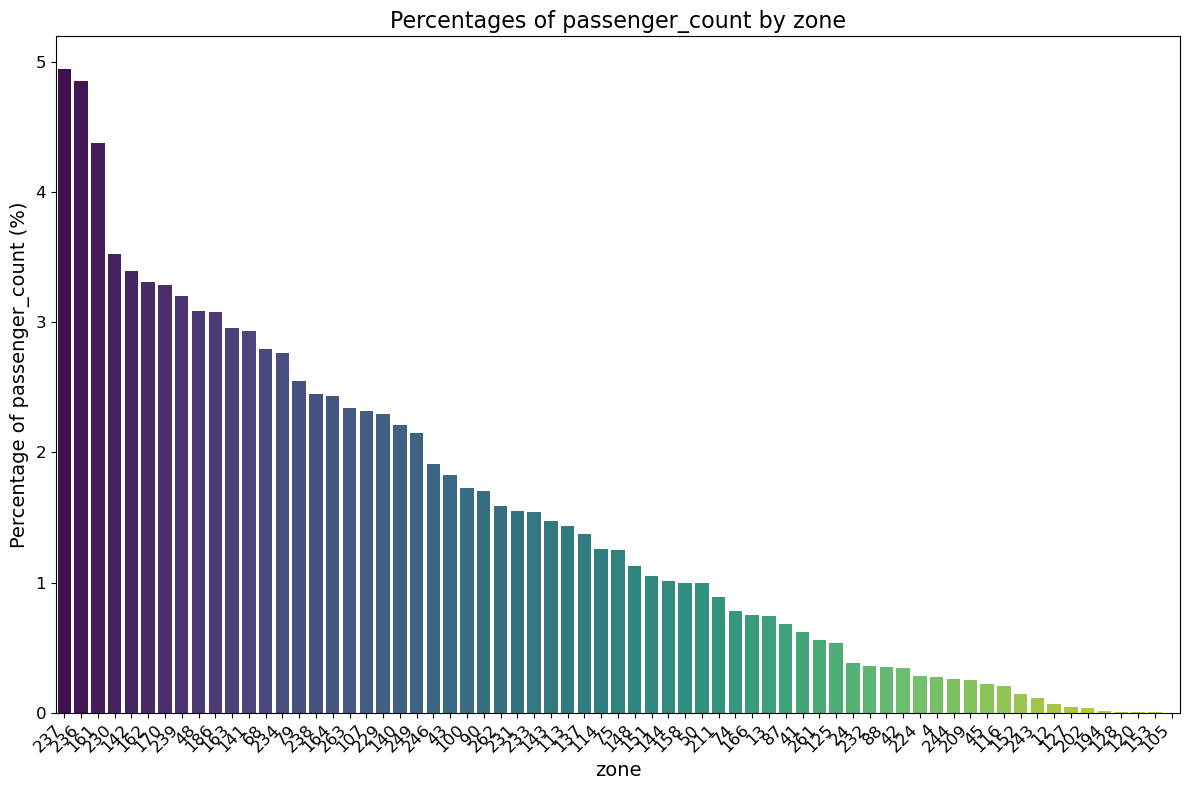

In [54]:
def plot_passenger_percentages(df, feature):
    # Calculate the total passenger_count for each value in the feature
    passenger_counts = df.groupby(feature)["passenger_count"].sum()

    # Calculate proportions
    proportions = passenger_counts / passenger_counts.sum() * 100  # Convert to percentage

    # Sort based on the proportions (descending order)
    sorted_proportions = proportions.sort_values(ascending=False)

    # Plot the proportions using seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_proportions.index, y=sorted_proportions.values, order=sorted_proportions.index, palette="viridis")
    
    # Plot title and labels
    plt.title(f"Percentages of passenger_count by {feature}", fontsize=16)
    plt.ylabel("Percentage of passenger_count (%)", fontsize=14)
    plt.xlabel(feature, fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# List of columns to group by
groupby_columns = ["hour", "day_of_week", "week", "month", "day_of_month", "year_month", "zone"]

# Compute and plot percentages of passenger_count for each category
for column in groupby_columns:
    plot_passenger_percentages(df, column)

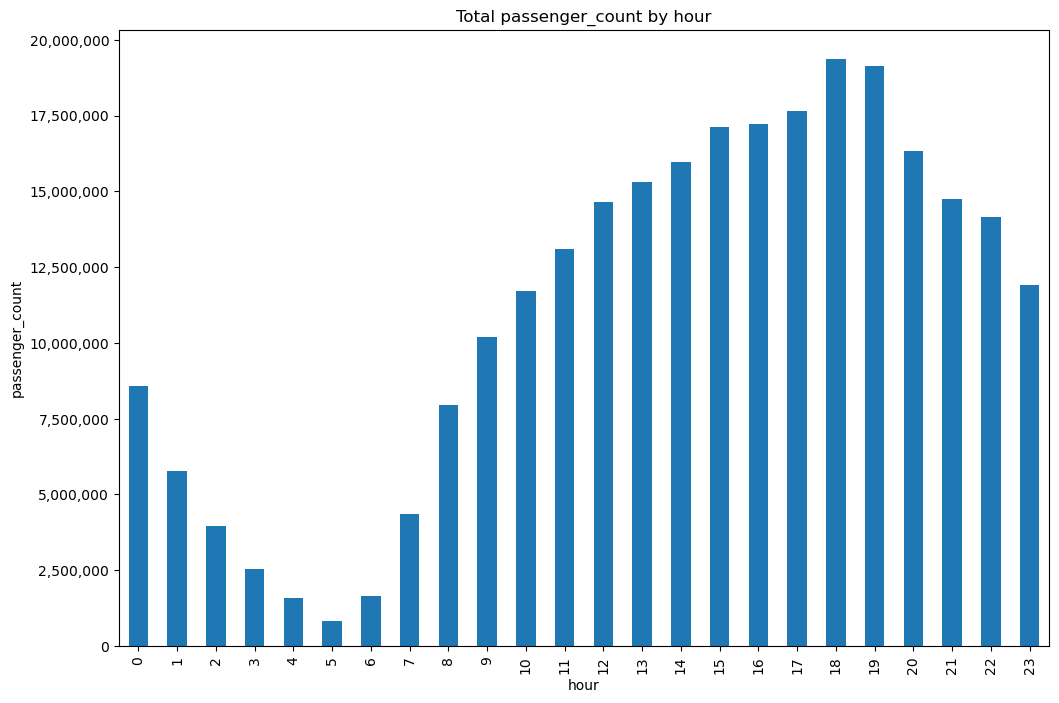

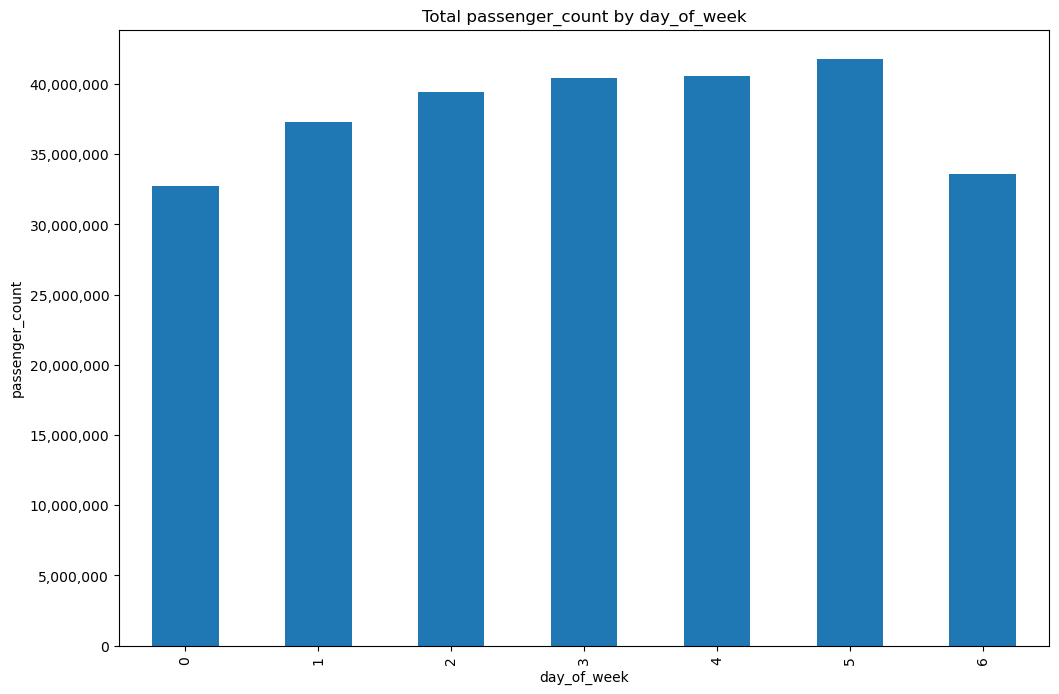

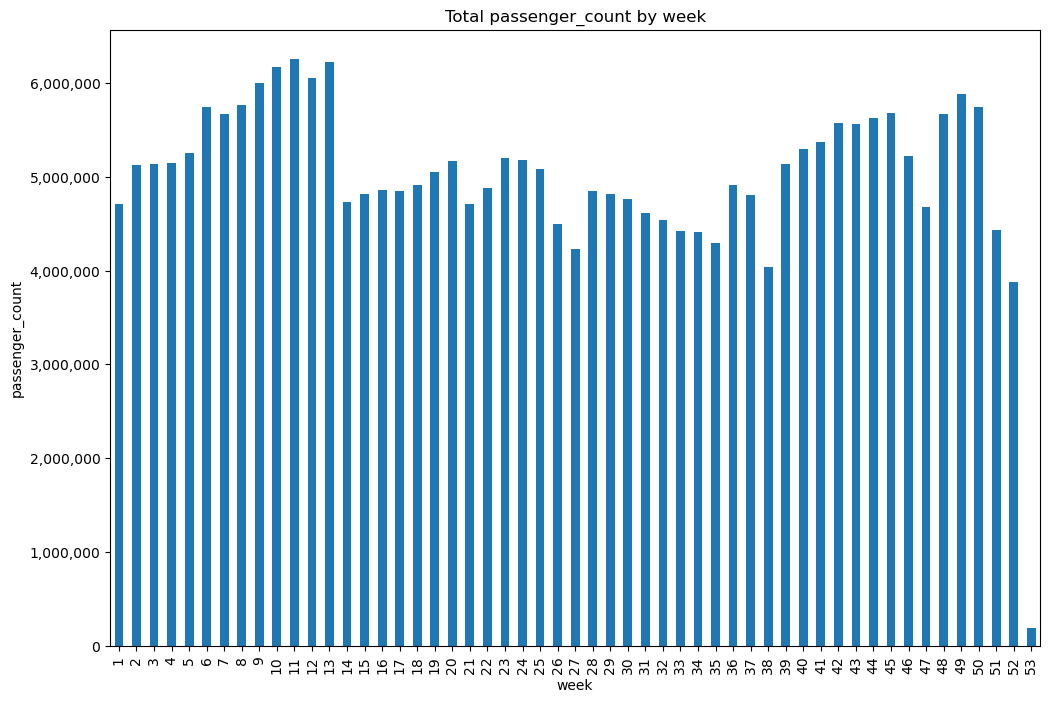

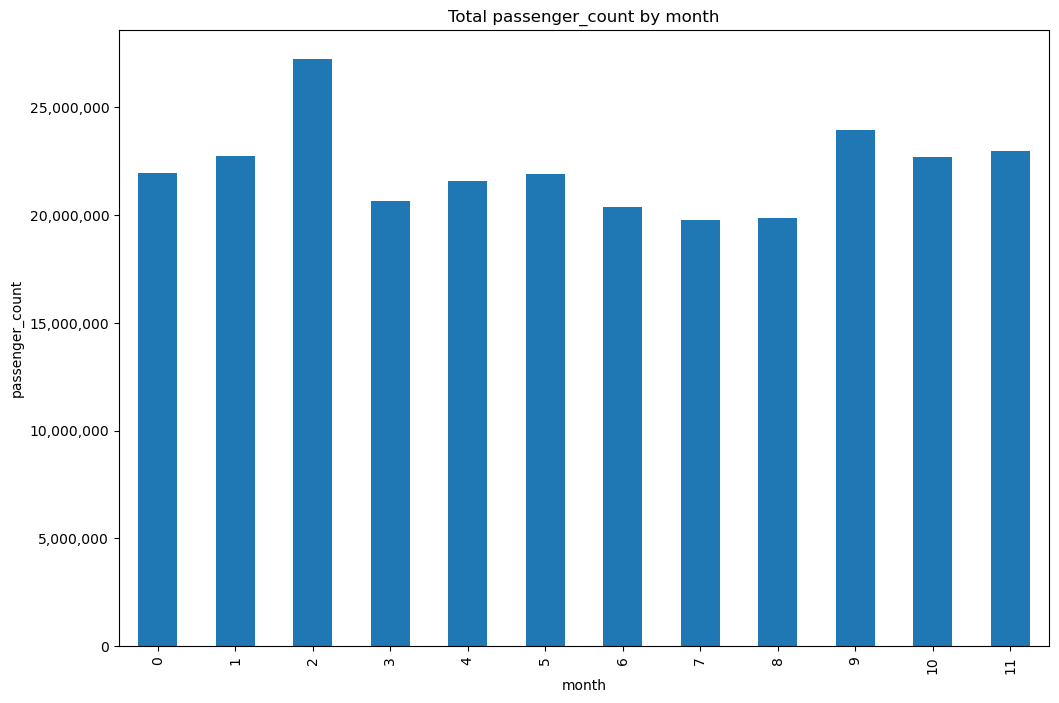

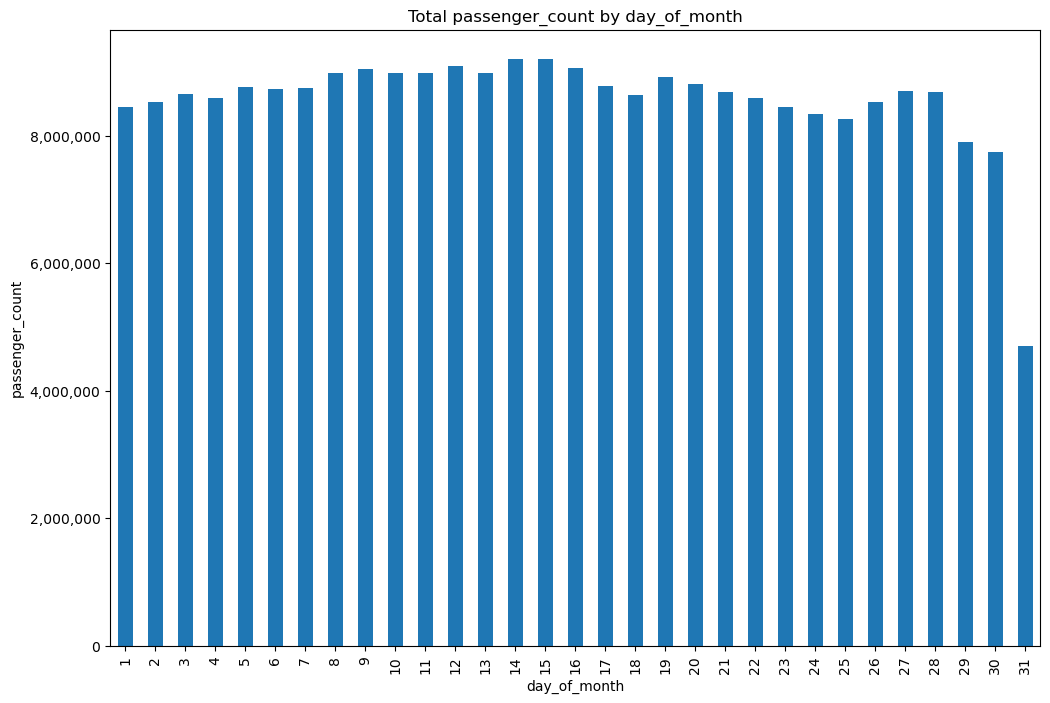

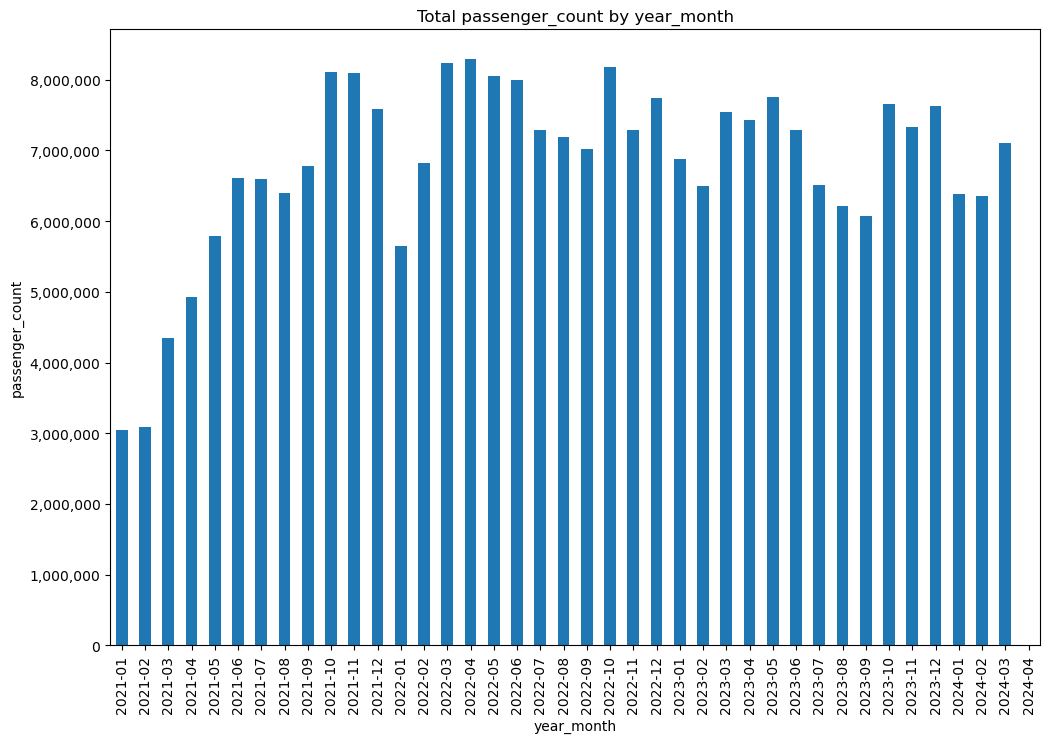

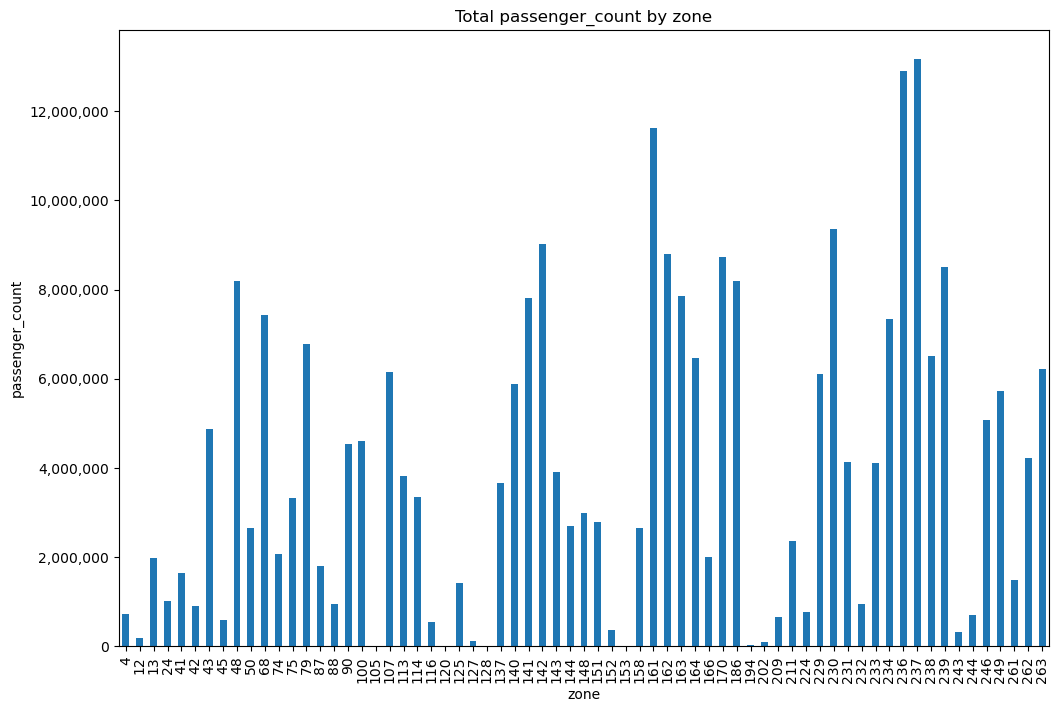

In [27]:
def plot_passenger_count(df, feature):
    # Calculate the total passenger_count for each value in the feature
    passenger_counts = df.groupby(feature)["passenger_count"].sum()

    # Plot the total passenger_count
    fig, ax = plt.subplots(figsize=(12, 8))
    passenger_counts.plot(kind="bar", ax=ax)
    ax.set_title(f"Total passenger_count by {feature}")
    ax.set_ylabel("passenger_count")
    ax.set_xlabel(feature)
    
    # Set y-axis tick format to non-scientific notation
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: format(int(x), ',')))
    
    plt.show()

# List of columns to group by
groupby_columns = ["hour", "day_of_week", "week", "month", "day_of_month", "year_month", "zone"]

# Compute and plot total passenger_count for each category
for column in groupby_columns:
    plot_passenger_count(df, column)

In [28]:
def calculate_top_zones(data):
    # Group by 'zone' and sum the 'passenger_count'
    zone_counts = data.groupby('zone')['passenger_count'].sum().reset_index()
    
    # Sort by 'passenger_count' descending and select top 17
    top_zones = zone_counts.nlargest(10, 'passenger_count')
    
    return top_zones

In [29]:
def plot_top_zones(top_zones):
    # Sort top_zones by 'passenger_count' in descending order
    top_zones = top_zones.sort_values(by='passenger_count', ascending=False)
    
    # Set up the plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='zone', y='passenger_count', data=top_zones, palette='viridis', order=top_zones['zone'])
    
    # Customize labels and title
    plt.xlabel('Zone')
    plt.ylabel('Total Passenger Count')
    plt.title('Top 10 Zones by Passenger Count (Highest to Lowest)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Display the plot
    plt.show()

C:\Users\35385\AppData\Local\Temp\ipykernel_21664\4246955726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='zone', y='passenger_count', data=top_zones, palette='viridis', order=top_zones['zone'])


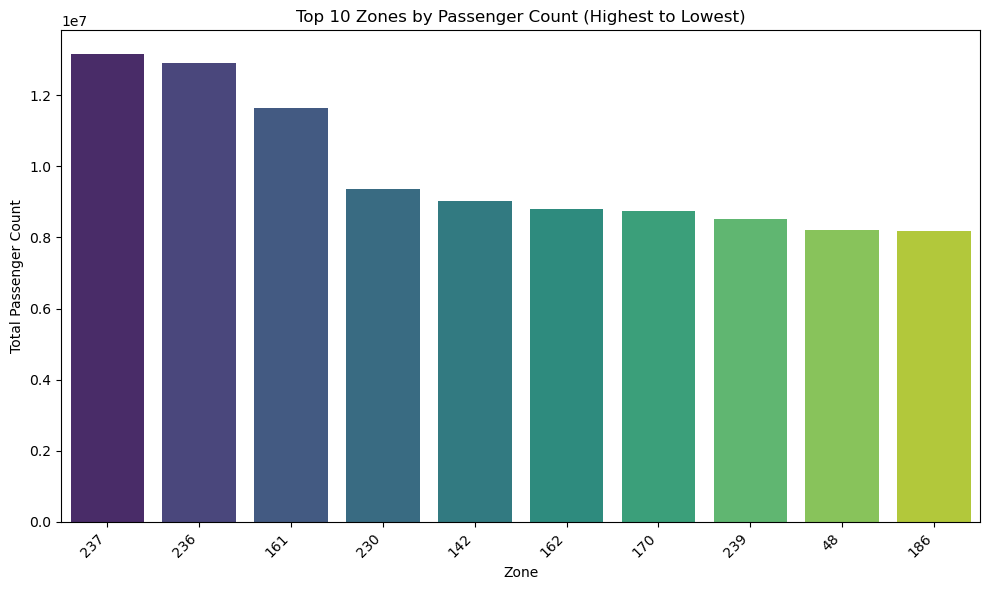

In [30]:
top_zones = calculate_top_zones(df)

plot_top_zones(top_zones)

In [32]:
geojson_manhat_direct = os.path.join(os.getcwd(), "..", "Datasets", "taxi_other")

# Define the directory where the data is located relative to the current working directory
print("Taxi Zone CSV Directory:", geojson_manhat_direct)

# Define the file path relative to the data directory
geojson_manhat = os.path.join(cwd, geojson_manhat_direct, "taxi_zones_manhattan.geojson")

gdf = gpd.read_file(geojson_manhat)

Taxi Zone CSV Directory: c:\Users\35385\Desktop\CS_Summer_2024\Shared_GH\New-York-App\data-analytics\analysis\..\Datasets\taxi_other


In [33]:
print(gdf.head())
print(gdf.crs)  # Check the Coordinate Reference System (CRS)

           shape_area objectid       shape_leng location_id  \
0   0.000111871946192        4  0.0435665270921           4   
1  0.0000607235737749       24  0.0469999619287          24   
2  0.0000415116236727       12  0.0366613013579          12   
3   0.000149358592917       13  0.0502813228631          13   
4   0.000143093037737       41   0.052793109453          41   

                zone    borough  \
0      Alphabet City  Manhattan   
1       Bloomingdale  Manhattan   
2       Battery Park  Manhattan   
3  Battery Park City  Manhattan   
4     Central Harlem  Manhattan   

                                            geometry  
0  MULTIPOLYGON (((-73.97177 40.72582, -73.97179 ...  
1  MULTIPOLYGON (((-73.95954 40.79872, -73.96004 ...  
2  MULTIPOLYGON (((-74.01566 40.70483, -74.01540 ...  
3  MULTIPOLYGON (((-74.01244 40.71906, -74.01282 ...  
4  MULTIPOLYGON (((-73.94774 40.80960, -73.94506 ...  
EPSG:4326


In [34]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   shape_area   69 non-null     object  
 1   objectid     69 non-null     object  
 2   shape_leng   69 non-null     object  
 3   location_id  69 non-null     object  
 4   zone         69 non-null     object  
 5   borough      69 non-null     object  
 6   geometry     69 non-null     geometry
dtypes: geometry(1), object(6)
memory usage: 3.9+ KB


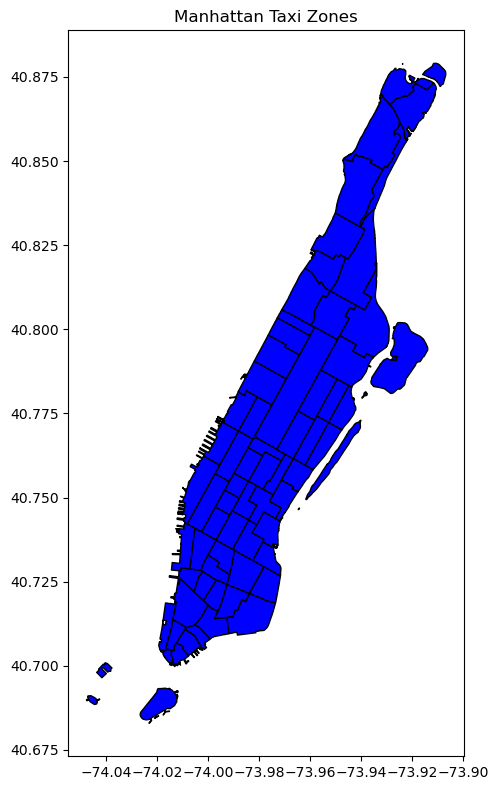

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the GeoDataFrame
gdf.plot(ax=ax, color='blue', edgecolor='black')

# Add a title
ax.set_title('Manhattan Taxi Zones')

# Display the plot
plt.tight_layout()
plt.show()

In [36]:
zone_passenger_counts = df.groupby('zone')['passenger_count'].sum().reset_index()


In [37]:
zone_passenger_counts

,zone,passenger_count
0,4,728816
1,12,174798
2,13,1979200
3,24,1006061
4,41,1642909
...,...,...
62,246,5079798
63,249,5722272
64,261,1480053
65,262,4215115


In [38]:
zone_passenger_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   zone             67 non-null     int64
 1   passenger_count  67 non-null     int64
dtypes: int64(2)
memory usage: 1.2 KB


In [39]:
# Rename columns
gdf.rename(columns={'zone': 'area', 'objectid': 'zone'}, inplace=True)
# Convert 'zone' column to integer
gdf['zone'] = gdf['zone'].astype(int)
merged = gdf.merge(zone_passenger_counts, on='zone')


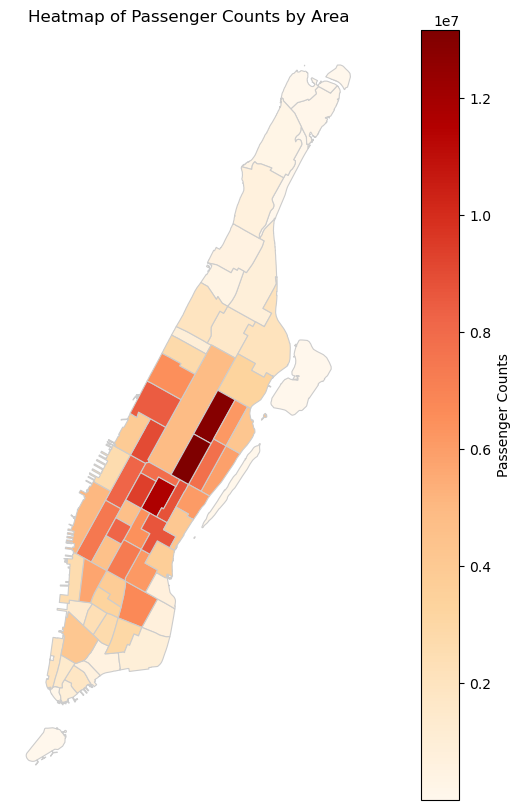

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))  # Increase figsize for larger plot
ax.set_title('Heatmap of Passenger Counts by Area')

# Plot the GeoDataFrame with 'passenger_count' as the variable to visualize
merged.plot(column='passenger_count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Passenger Counts"})

# Customize the legend if it exists
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.15, 1))  # Adjust legend position

# Optional: Format colorbar tick labels to disable scientific notation
formatter = plt.FuncFormatter(lambda x, _: f'{x:.0f}')  # Format numbers with no decimal places
cbar = ax.collections[0].colorbar  # Get the colorbar associated with the plot
if cbar:
    cbar.ax.yaxis.set_major_formatter(formatter)

# Optional: Add labels or other customization
ax.set_axis_off()  # Turn off axis if not needed

plt.show()

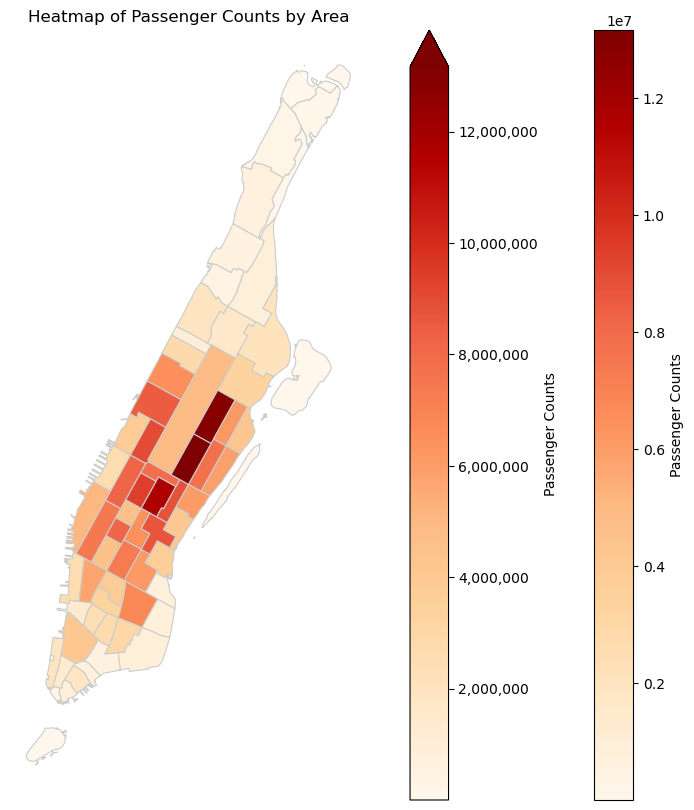

In [69]:
# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.set_title('Heatmap of Passenger Counts by Area')

# Plot the GeoDataFrame with 'passenger_count' as the variable to visualize
merged.plot(column='passenger_count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Passenger Counts"})

# Customize the legend if it exists
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((1.15, 1))  # Adjust legend position

# Find the range of passenger_count
min_count = merged['passenger_count'].min()
max_count = merged['passenger_count'].max()

# Create colorbar linked to the plotted data
# Ensure that the colorbar is based on the current plot and not the default one
# Here, we directly link to the plot's color mapping
norm = plt.Normalize(vmin=min_count, vmax=max_count)
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, extend='max')
cbar.set_label('Passenger Counts')

# Format colorbar tick labels to add commas and disable scientific notation
formatter = plt.FuncFormatter(lambda x, _: format(int(x), ','))
cbar.ax.yaxis.set_major_formatter(formatter)

# Optional: Add labels or other customization
ax.set_axis_off()  # Turn off axis if not needed

plt.show()